# Import Libraries

In [42]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torch
import torchaudio
from torch.utils.data import DataLoader, Dataset

import IPython.display as ipd

import tensorflow as tf
from tensorflow.keras import layers, models
from transformers import Wav2Vec2Model, Wav2Vec2Processor,TrainingArguments, Wav2Vec2ForSequenceClassification

In [43]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

False
[]


# Exact Dataset Path

In [44]:
#from google.colab import drive
#drive.mount('/content/drive/')

# Replace with your actual dataset folder path
dataset_path = 'E:\\Downloads\\BanglaSER'
x = 0
for root, dirs, files in os.walk(dataset_path):

    for file in files:
        if file.endswith('.wav'):  # Assuming your audio files are in .wav format
            print(os.path.join(root, file))
            x = x + 1

print("Total files = ", x)

E:\Downloads\BanglaSER\Actor 01\03-01-01-01-01-01-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-01-01-01-02-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-01-01-01-03-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-01-01-02-01-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-01-01-02-02-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-01-01-02-03-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-01-01-03-01-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-01-01-03-02-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-01-01-03-03-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-02-01-01-01-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-02-01-01-02-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-02-01-01-03-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-02-01-02-01-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-02-01-02-02-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-02-01-02-03-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-02-01-03-01-01.wav
E:\Downloads\BanglaSER\Actor 01\03-01-02-01-03-02-01.wav
E:\Downloads\BanglaSER\Actor 01

# Load Audio Dataset Function

In [45]:
def load_audio_dataset(dataset_path):
    paths = []
    labels = []

    label_mapping = {
        "01": "happy",
        "02": "sad",
        "03": "angry",
        "04": "surprise",
        "05": "neutral"
    }

    for actor in range(1, 35):  # Loop through Actor 01 to Actor 34
        actor_folder = f"Actor {actor:02d}"  # Format as 'Actor 01', 'Actor 02', ...
        actor_path = os.path.join(dataset_path, actor_folder)

        if not os.path.isdir(actor_path):
            continue

        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Ensure it's an audio file
                parts = file.split("-")
                if len(parts) < 3:
                    continue

                emotion_label = parts[2]  # 3rd number in filename
                emotion = label_mapping.get(emotion_label, "unknown")

                file_path = os.path.join(actor_path, file)
                paths.append(file_path)
                labels.append(emotion)

    return paths, labels

# Example usage
# current_dir = os.getcwd() # Get the current script directory
# dataset_path = os.path.join(current_dir, "B-SER dataset")
paths, labels = load_audio_dataset(dataset_path)

print(f"Loaded {len(paths)} audio files")
print(f"Sample path: {paths[0]}")
print(f"Sample label: {labels[0]}")

Loaded 1467 audio files
Sample path: E:\Downloads\BanglaSER\Actor 01\03-01-01-01-01-01-01.wav
Sample label: happy


# KUET and BANGLASER mixing

In [5]:
import os

def load_audio_dataset(dataset_path):
    paths = []
    labels = []

    label_mapping = {
        "01": "happy",
        "02": "sad",
        "03": "angry",
        "04": "surprise",
        "05": "neutral"
    }

    for actor in range(1, 35):  # Loop through Actor 01 to Actor 34
        actor_folder = f"Actor {actor:02d}"  # Format as 'Actor 01', 'Actor 02', ...
        actor_path = os.path.join(dataset_path, actor_folder)

        if not os.path.isdir(actor_path):
            continue

        for file in os.listdir(actor_path):
            if file.endswith(".wav"):  # Ensure it's an audio file
                parts = file.split("-")
                if len(parts) < 3:
                    continue

                emotion_label = parts[2]  # 3rd number in filename
                emotion = label_mapping.get(emotion_label, "unknown")

                file_path = os.path.join(actor_path, file)
                paths.append(file_path)
                labels.append(emotion)

    return paths, labels

def load_mendeley_dataset(dataset_path):
    paths = []
    labels = []

    label_mapping = {
        "Angry (High)": "angry",
        "Angry (Low)": "angry",
        "Disgust (High)": "disgust",
        "Disgust (Low)": "disgust",
        "Happy (High)": "happy",
        "Happy (Low)": "happy",
        "Neutral": "neutral",
        "Sad (High)": "sad",
        "Sad (Low)": "sad"
    }

    for emotion_folder in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion_folder)

        if not os.path.isdir(emotion_path):
            continue

        # Extract label from folder name
        emotion_label = label_mapping.get(emotion_folder)

        if emotion_label is None:
            print(f"Skipping folder {emotion_folder} as it does not match any known emotion")
            continue

        for file in os.listdir(emotion_path):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_path, file)
                paths.append(file_path)
                labels.append(emotion_label)
            
    return paths, labels

# First dataset
dataset_path = r'E:\Downloads\BanglaSER'
paths1, labels1 = load_audio_dataset(dataset_path)

# Second dataset
mendeley_dataset_path = r"E:\Downloads\KUET Bangla Emotional Speech (KBES) Dataset"  # Replace with the actual path
paths2, labels2 = load_mendeley_dataset(mendeley_dataset_path)

# Combine the datasets
paths = paths1 + paths2
labels = labels1 + labels2

print(f"Total Loaded Audio Files: {len(paths)}")
print(f"B-SER dataset size: {len(paths1)}")
print(f"Mendeley dataset size: {len(paths2)}")
print(f"Sample path: {paths[0]}")
print(f"Sample label: {labels[0]}")
print(f"Sample path: {paths[-1]}")
print(f"Sample label: {labels[-1]}")


Total Loaded Audio Files: 2367
B-SER dataset size: 1467
Mendeley dataset size: 900
Sample path: E:\Downloads\BanglaSER\Actor 01\03-01-01-01-01-01-01.wav
Sample label: happy
Sample path: E:\Downloads\KUET Bangla Emotional Speech (KBES) Dataset\Sad (Low)\3-1-1-050.wav
Sample label: sad


# Play Audio Function

In [46]:
def play_audio(file_path, use_ipython=True):
    if use_ipython:
        return ipd.Audio(file_path)
    else:
        audio = AudioSegment.from_wav(file_path)
        play(audio)

# Testing

In [47]:
print(os.listdir(dataset_path))
print(os.listdir(mendeley_dataset_path))

['Actor 01', 'Actor 02', 'Actor 03', 'Actor 04', 'Actor 05', 'Actor 06', 'Actor 07', 'Actor 08', 'Actor 09', 'Actor 10', 'Actor 11', 'Actor 12', 'Actor 13', 'Actor 14', 'Actor 15', 'Actor 16', 'Actor 17', 'Actor 18', 'Actor 19', 'Actor 20', 'Actor 21', 'Actor 22', 'Actor 23', 'Actor 24', 'Actor 25', 'Actor 26', 'Actor 27', 'Actor 28', 'Actor 29', 'Actor 30', 'Actor 31', 'Actor 32', 'Actor 33', 'Actor 34']
['Angry (High)', 'Angry (Low)', 'Disgust (High)', 'Disgust (Low)', 'Happy (High)', 'Happy (Low)', 'Neutral', 'Sad (High)', 'Sad (Low)']


In [48]:
play_audio(paths[0])

In [49]:
# paths[:]

In [50]:
labels[:5]

['happy', 'happy', 'happy', 'happy', 'happy']

# Create DataFrame

In [51]:
df = pd.DataFrame()
df['audioPaths'] = paths
df['labels'] = labels
df = df.drop(df[df['labels'] == 'disgust'].index).reset_index(drop=True)

df.head()

audioPaths labels
0  E:\Downloads\BanglaSER\Actor 01\03-01-01-01-01...  happy
1  E:\Downloads\BanglaSER\Actor 01\03-01-01-01-01...  happy
2  E:\Downloads\BanglaSER\Actor 01\03-01-01-01-01...  happy
3  E:\Downloads\BanglaSER\Actor 01\03-01-01-01-02...  happy
4  E:\Downloads\BanglaSER\Actor 01\03-01-01-01-02...  happy

# Dataframe Details

In [52]:
df['labels'].value_counts()

labels
happy       306
sad         306
angry       306
surprise    306
neutral     243
Name: count, dtype: int64

<Axes: xlabel='labels', ylabel='count'>

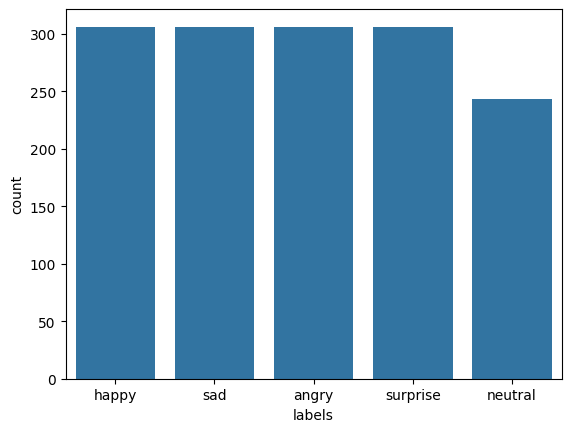

In [53]:
sns.countplot(data = df, x = 'labels')

# Waveplot Functions

In [54]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size = 20)
    librosa.display.waveshow(data,sr = sr)
    plt.show()

In [55]:
def spectogram(data, sr, emmotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size = 20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')

# Waveplot Test

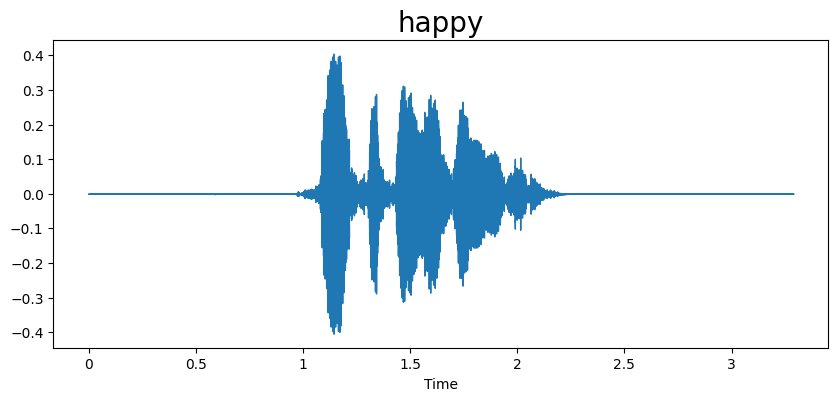

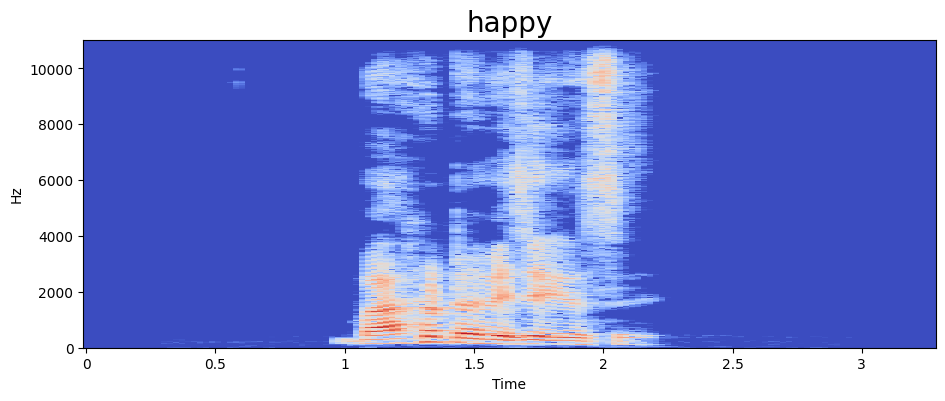

In [56]:
emotion = 'happy'
path = np.array(df['audioPaths'][df['labels'] == emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data,sampling_rate,emotion)
spectogram(data,sampling_rate,emotion)
Audio(path)

# Waveplot 1 Example of each Target Class

Emotion: happy


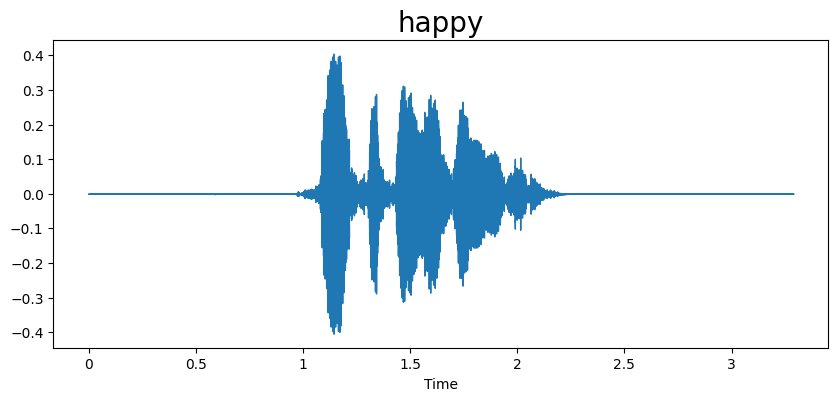


--------------------------------------------------

Emotion: sad


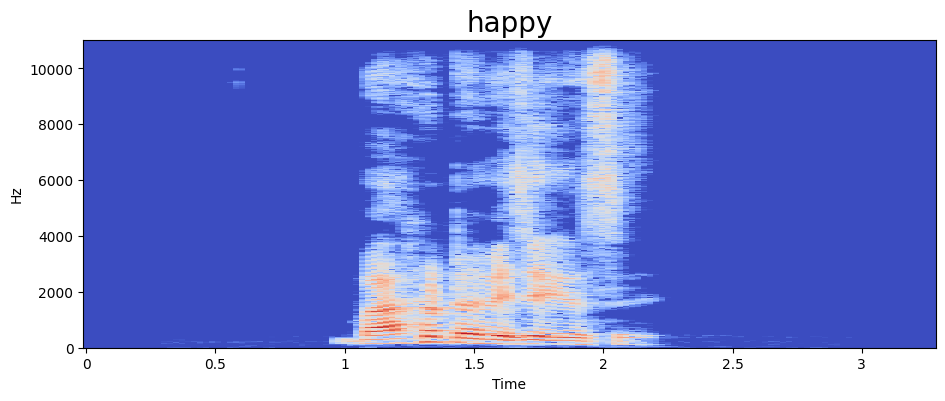

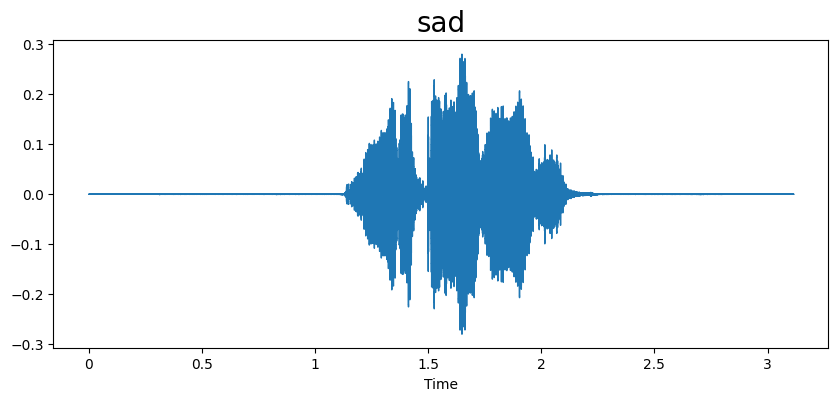


--------------------------------------------------

Emotion: angry


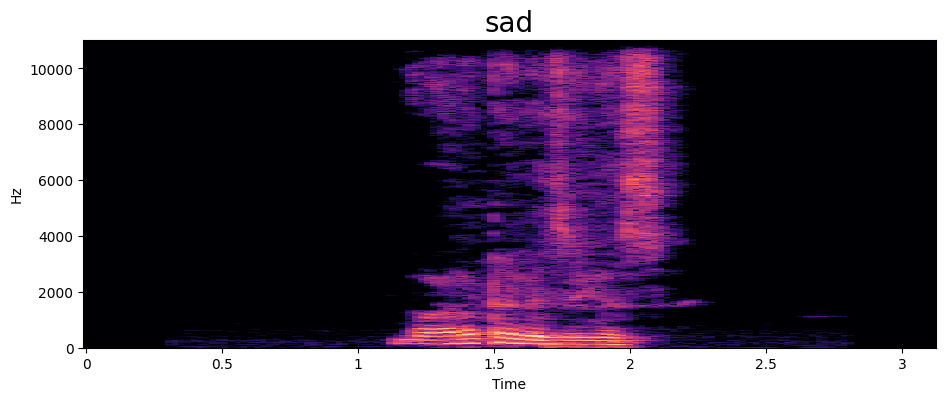

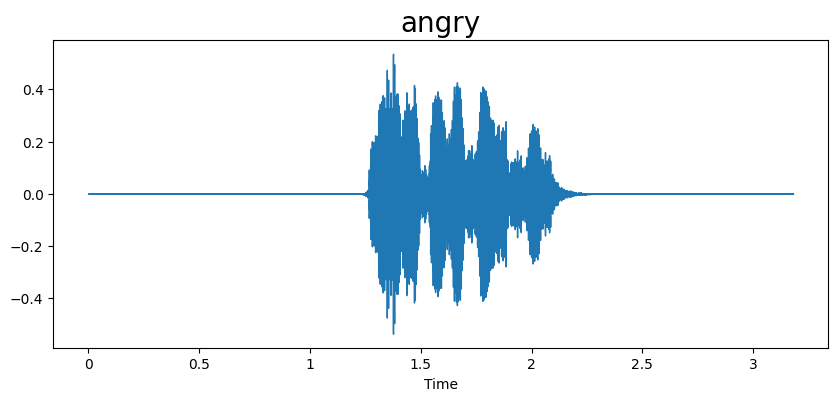


--------------------------------------------------

Emotion: surprise


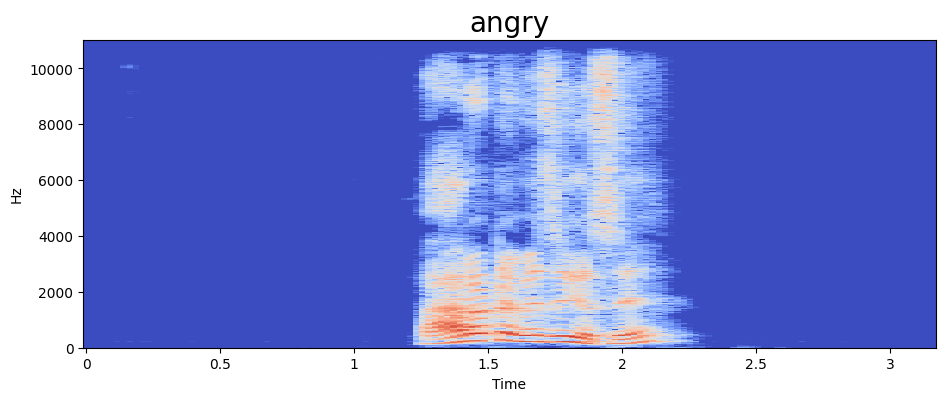

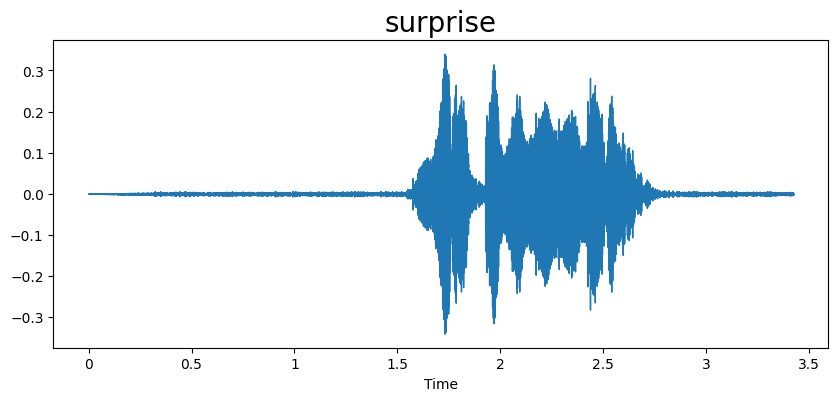


--------------------------------------------------

Emotion: neutral


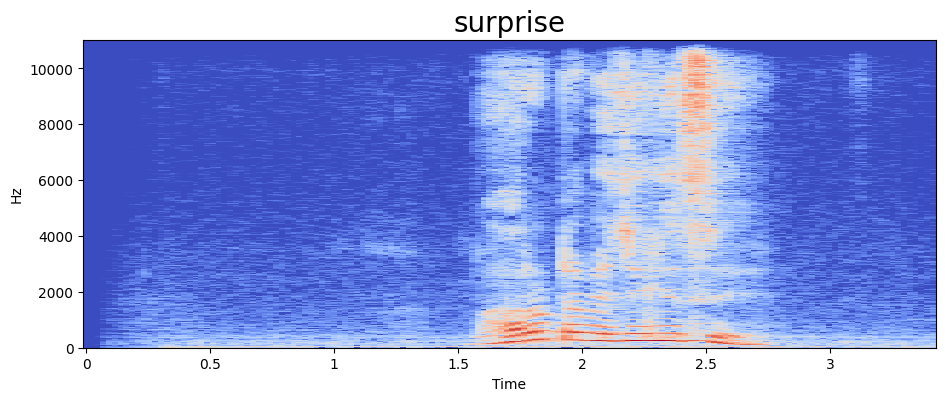

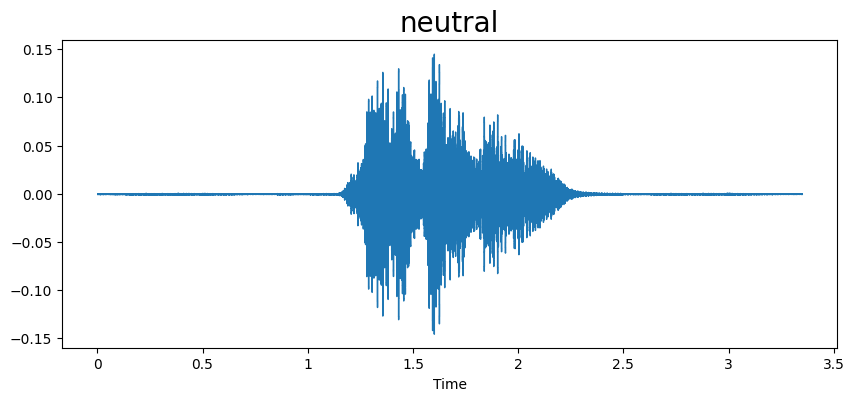


--------------------------------------------------



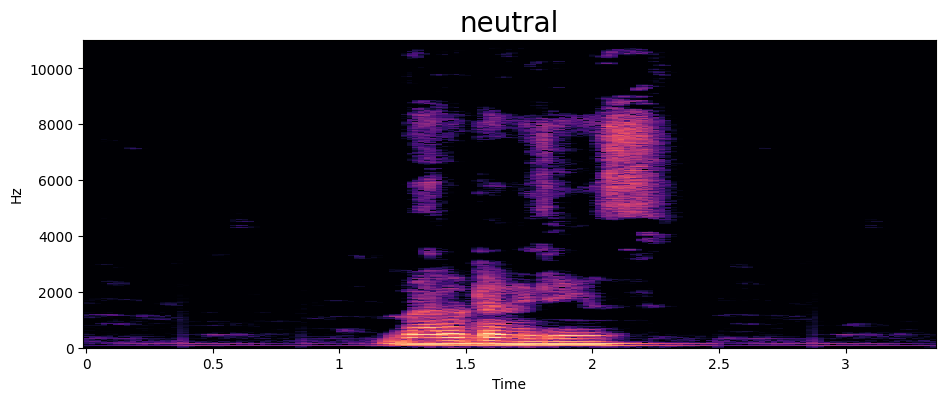

In [57]:
# Get unique emotion classes
unique_emotions = df['labels'].unique()

# Loop through each emotion and display one example
for emotion in unique_emotions:
    path = np.array(df['audioPaths'][df['labels'] == emotion])[0]  # Get one sample for each emotion
    data, sampling_rate = librosa.load(path)

    print(f"Emotion: {emotion}")

    waveplot(data, sampling_rate, emotion)
    spectogram(data, sampling_rate, emotion)

    display(Audio(path))  # Play the audio
    print("\n" + "-"*50 + "\n")  # Separator for clarity

In [58]:
from sklearn.model_selection import train_test_split

def stratified_split(df, test_size=0.15, val_size=0.15):
    train_val_df, test_df = train_test_split(df, test_size=test_size, stratify=df['labels'], random_state=42)

    val_size_adjusted = val_size / (1 - test_size)

    train_df, val_df = train_test_split(train_val_df, test_size=val_size_adjusted, stratify=train_val_df['labels'], random_state=42)

    return train_df, val_df, test_df

# Define split ratios
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Perform stratified split
train_df, val_df, test_df = stratified_split(df, test_size=test_ratio, val_size=val_ratio)

# Verify distribution of emotion classes in each split
train_distribution = train_df['labels'].value_counts(normalize=True)
val_distribution = val_df['labels'].value_counts(normalize=True)
test_distribution = test_df['labels'].value_counts(normalize=True)

print("Train set distribution:", train_distribution)
print("Validation set distribution:", val_distribution)
print("Test set distribution:", test_distribution)

Train set distribution: labels
sad         0.208577
surprise    0.208577
angry       0.208577
happy       0.208577
neutral     0.165692
Name: proportion, dtype: float64
Validation set distribution: labels
happy       0.210884
surprise    0.210884
angry       0.210884
sad         0.204082
neutral     0.163265
Name: proportion, dtype: float64
Test set distribution: labels
sad         0.210884
surprise    0.207483
angry       0.207483
happy       0.207483
neutral     0.166667
Name: proportion, dtype: float64


In [59]:
def check_audio_length(file_path):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=None)  # sr=None keeps the original sampling rate

    # Calculate the duration
    duration = len(audio) / sr  # Duration in seconds
    return duration

# Example usage:
train_df['audio_length'] = train_df['audioPaths'].apply(check_audio_length)

val_df['audio_length'] = val_df['audioPaths'].apply(check_audio_length)
test_df['audio_length'] = test_df['audioPaths'].apply(check_audio_length)

print(train_df[['audioPaths', 'audio_length']])
print(val_df[['audioPaths', 'audio_length']])
print(test_df[['audioPaths', 'audio_length']])


                                             audioPaths  audio_length
744   E:\Downloads\BanglaSER\Actor 18\03-01-02-01-03...      3.388146
712   E:\Downloads\BanglaSER\Actor 17\03-01-04-02-01...      3.550726
1144  E:\Downloads\BanglaSER\Actor 27\03-01-04-02-01...      3.056485
426   E:\Downloads\BanglaSER\Actor 10\03-01-03-02-02...      3.117688
414   E:\Downloads\BanglaSER\Actor 10\03-01-02-01-01...      3.037875
...                                                 ...           ...
1260  E:\Downloads\BanglaSER\Actor 30\03-01-03-02-01...      3.107778
1338  E:\Downloads\BanglaSER\Actor 32\03-01-01-01-03...      3.067188
1197  E:\Downloads\BanglaSER\Actor 28\03-01-05-01-01...      3.413696
788   E:\Downloads\BanglaSER\Actor 19\03-01-03-02-02...      3.215875
761   E:\Downloads\BanglaSER\Actor 18\03-01-04-02-02...      3.898792

[1026 rows x 2 columns]
                                             audioPaths  audio_length
460   E:\Downloads\BanglaSER\Actor 11\03-01-02-01-01...      3.45

In [60]:
# Define the target length in samples (3.5 seconds at 44.1 kHz)
target_length = int(3.5 * 44100)

def standardize_audio_length(file_path, target_length):
    # Load the audio file
    audio, sr = librosa.load(file_path, sr=44100)

    # Standardize the length
    if len(audio) < target_length:
        # Zero padding for shorter files
        audio = np.pad(audio, (0, target_length - len(audio)))
    elif len(audio) > target_length:
        # Truncate longer files
        audio = audio[:target_length]

    return audio

# Apply the standardization to all audio files in the dataframe
train_df['standardized_audio'] = train_df['audioPaths'].apply(lambda x: standardize_audio_length(x, target_length))
val_df['standardized_audio'] = val_df['audioPaths'].apply(lambda x: standardize_audio_length(x, target_length))
test_df['standardized_audio'] = test_df['audioPaths'].apply(lambda x: standardize_audio_length(x, target_length))

In [61]:
def check_audio_length(audio, sr=44100):
    # Calculate the duration
    duration = len(audio) / sr  # Duration in seconds
    return duration
train_df['audio_length'] = train_df['standardized_audio'].apply(lambda x: check_audio_length(x))
print(train_df[['audioPaths', 'audio_length']])

val_df['audio_length'] = val_df['standardized_audio'].apply(lambda x: check_audio_length(x))
print(val_df[['audioPaths', 'audio_length']])

test_df['audio_length'] = test_df['standardized_audio'].apply(lambda x: check_audio_length(x))
print(test_df[['audioPaths', 'audio_length']])

from IPython.display import Audio

# Function to play audio
def play_audio(audio, sr=44100):
    return Audio(audio, rate=sr)

# Play the first 5 standardized audio files
for i in range(5):
    print(f"Playing audio file {i+1}:")
    display(play_audio(train_df['standardized_audio'].iloc[i]))
    display(train_df['standardized_audio'].iloc[i])


                                             audioPaths  audio_length
744   E:\Downloads\BanglaSER\Actor 18\03-01-02-01-03...           3.5
712   E:\Downloads\BanglaSER\Actor 17\03-01-04-02-01...           3.5
1144  E:\Downloads\BanglaSER\Actor 27\03-01-04-02-01...           3.5
426   E:\Downloads\BanglaSER\Actor 10\03-01-03-02-02...           3.5
414   E:\Downloads\BanglaSER\Actor 10\03-01-02-01-01...           3.5
...                                                 ...           ...
1260  E:\Downloads\BanglaSER\Actor 30\03-01-03-02-01...           3.5
1338  E:\Downloads\BanglaSER\Actor 32\03-01-01-01-03...           3.5
1197  E:\Downloads\BanglaSER\Actor 28\03-01-05-01-01...           3.5
788   E:\Downloads\BanglaSER\Actor 19\03-01-03-02-02...           3.5
761   E:\Downloads\BanglaSER\Actor 18\03-01-04-02-02...           3.5

[1026 rows x 2 columns]
                                             audioPaths  audio_length
460   E:\Downloads\BanglaSER\Actor 11\03-01-02-01-01...          

array([ 1.0516119e-05,  1.6918904e-05, -2.3911769e-05, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

Playing audio file 2:


array([-2.2735596e-03, -1.8157959e-03, -2.1972656e-03, ...,
        1.3732910e-04,  1.3732910e-04,  9.1552734e-05], dtype=float32)

Playing audio file 3:


array([0.00073242, 0.00085449, 0.00106812, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

Playing audio file 4:


array([7.7272729e-05, 1.1428851e-04, 4.8566610e-05, ..., 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00], dtype=float32)

Playing audio file 5:


array([-5.2706196e-06,  1.8371764e-05, -5.8081314e-06, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def extract_mfcc(audio, sr=44100, n_mfcc=40, n_fft=1024, hop_length=512):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfcc

def pad_or_truncate(mfcc, target_length=300):
    if mfcc.shape[1] < target_length:
        pad_width = target_length - mfcc.shape[1]
        mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :target_length]
    return mfcc

# Apply MFCC extraction and padding to the standardized audio data
train_df['mfcc_features'] = train_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))

# Flatten MFCC features for scaling
mfcc_features = np.array(train_df['mfcc_features'].tolist())
mfcc_flattened = mfcc_features.reshape(mfcc_features.shape[0], -1)

# Scale the flattened MFCC features
scaler = MinMaxScaler()
scaled_mfcc = scaler.fit_transform(mfcc_flattened)

# Reshape back to original dimensions
scaled_mfcc = scaled_mfcc.reshape(mfcc_features.shape)

# Update the DataFrame with scaled MFCC features
train_df['mfcc_features'] = list(scaled_mfcc)

print("MFCC shape for the first 5 samples after scaling:")
for i in range(5):
    print(f"Sample {i+1}: {train_df['mfcc_features'].iloc[i].shape}")



MFCC shape for the first 5 samples after scaling:
Sample 1: (40, 300)
Sample 2: (40, 300)
Sample 3: (40, 300)
Sample 4: (40, 300)
Sample 5: (40, 300)


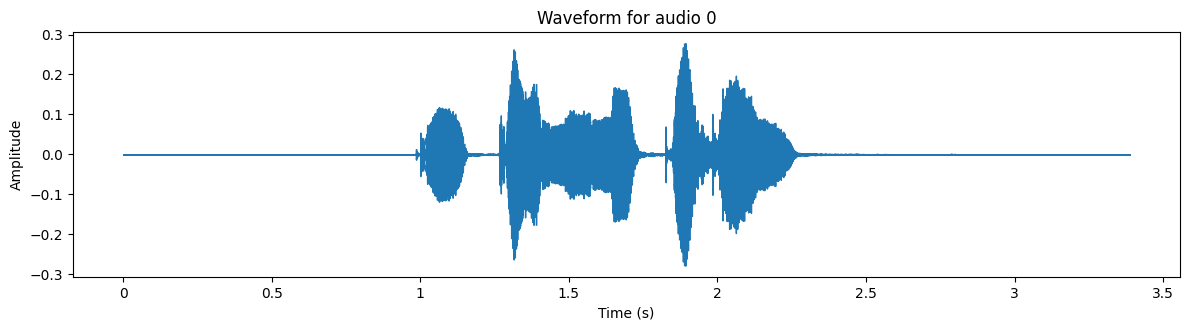

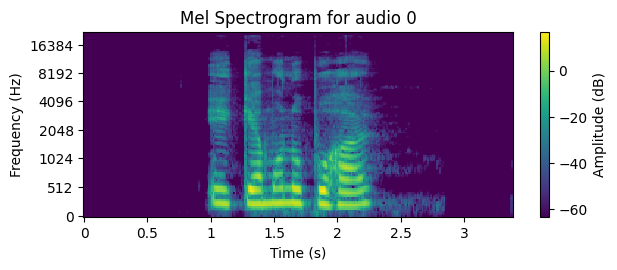

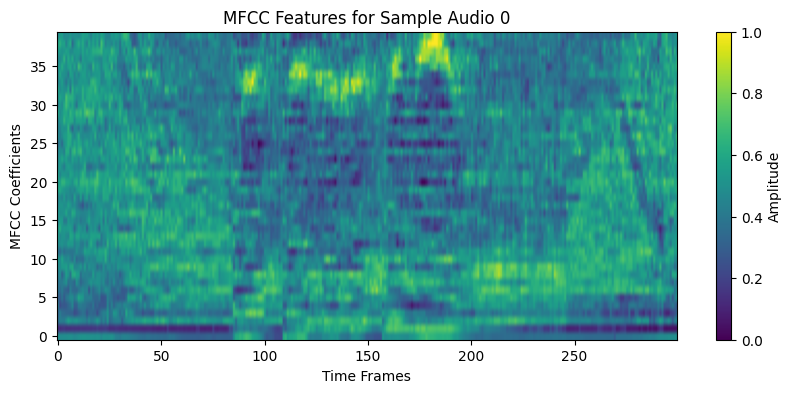

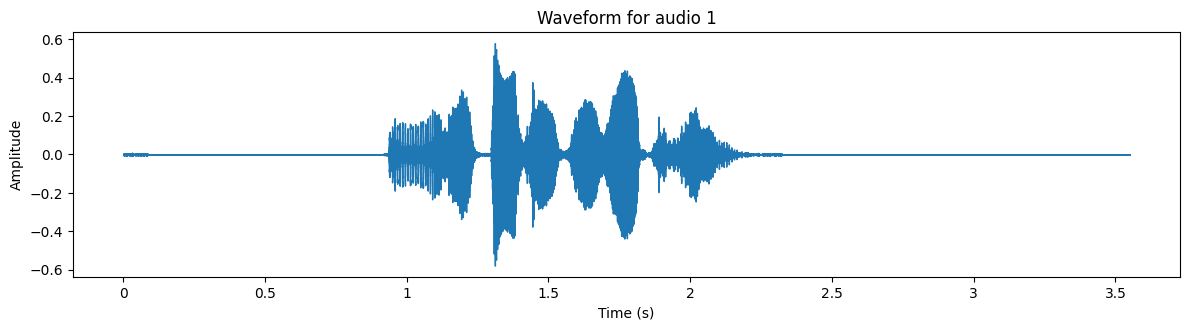

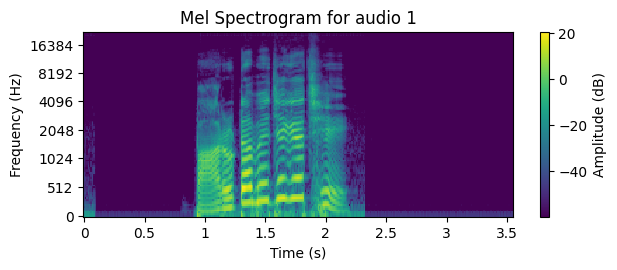

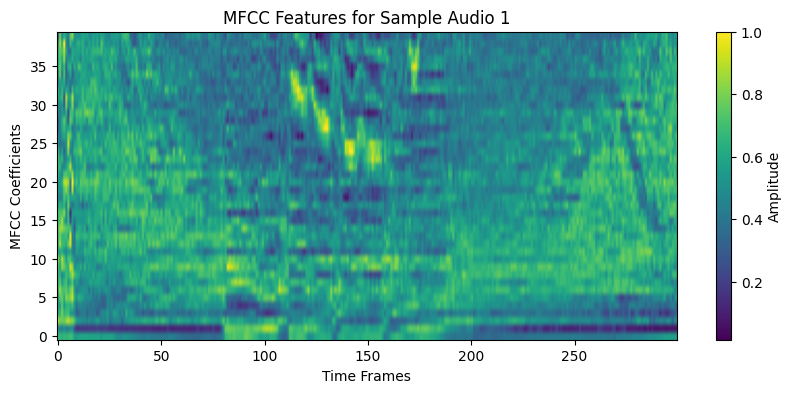

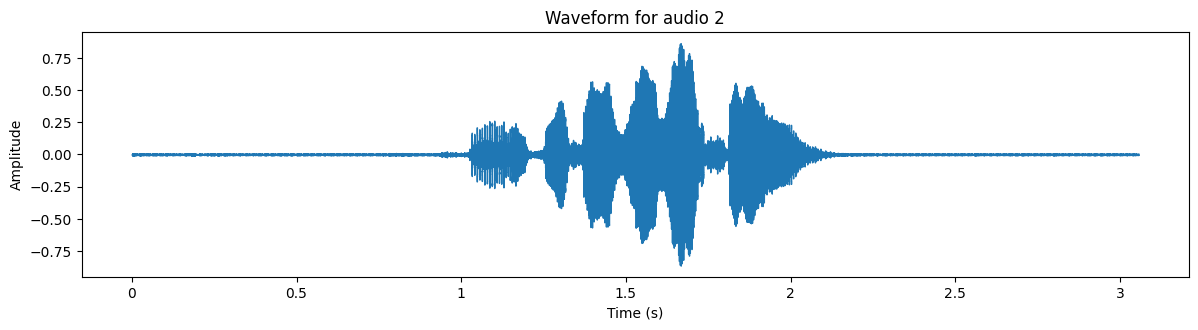

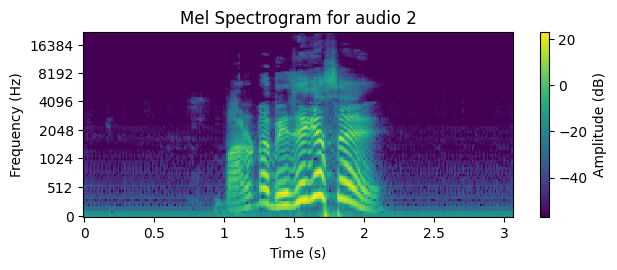

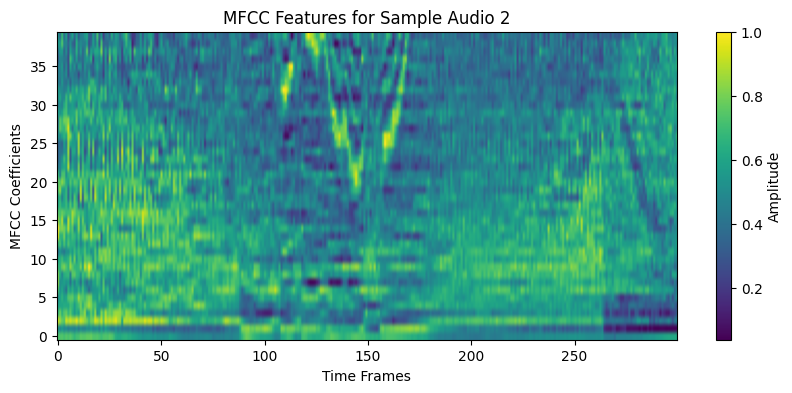

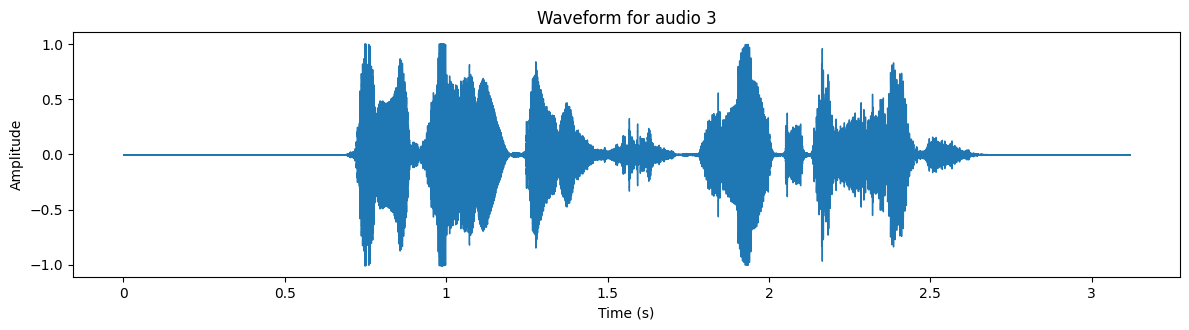

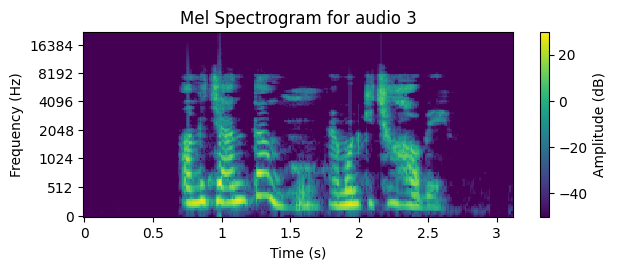

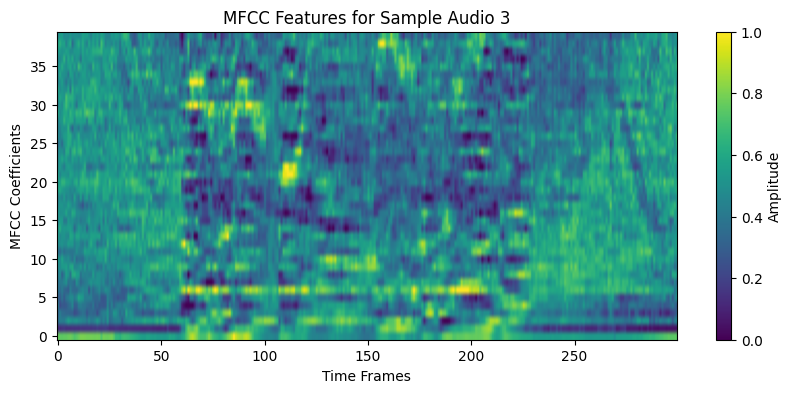

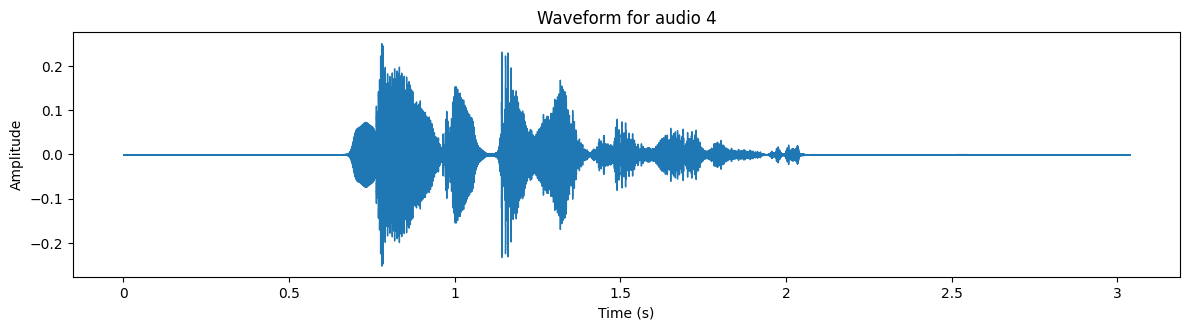

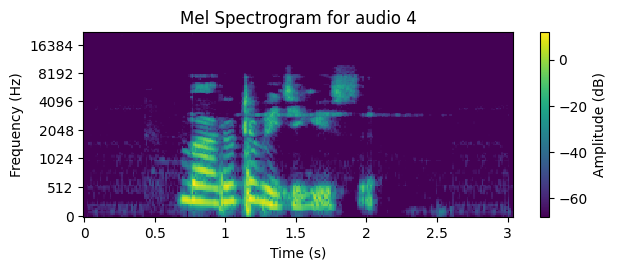

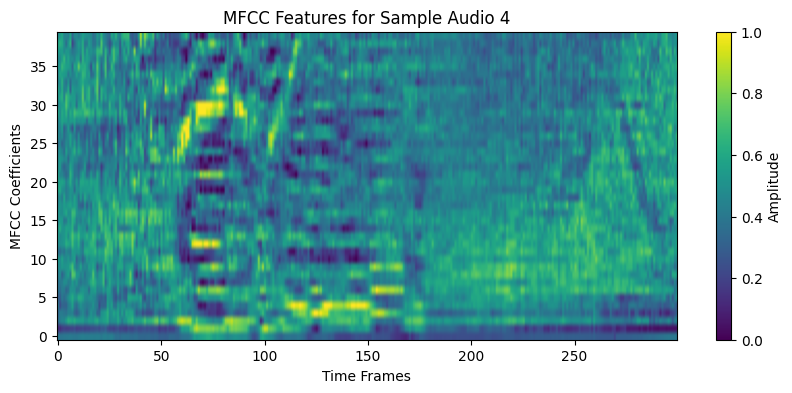

In [63]:
# Plot waveform and spectrogram for comparison
import librosa.display

# file_path = df['audioPaths'].iloc[1466]  # Path to the same sample audio
# audio, sr = librosa.load(file_path, sr=44100)

# plt.figure(figsize=(12, 6))

# Plot waveform
def showwave(audio,num):
  plt.figure(figsize=(12, 6))
  plt.subplot(2, 1, 1)
  librosa.display.waveshow(audio, sr=sr)
  plt.title('Waveform for audio ' + str(num))
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.tight_layout()
  plt.show()

# Plot spectrogram
def showspec(audio,num):
  plt.subplot(2, 1, 2)
  spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=1024, hop_length=512)
  log_spectrogram = librosa.power_to_db(spectrogram)
  librosa.display.specshow(log_spectrogram, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
  plt.title('Mel Spectrogram for audio ' + str(num))
  plt.colorbar(label='Amplitude (dB)')
  plt.xlabel('Time (s)')
  plt.ylabel('Frequency (Hz)')
  plt.tight_layout()
  plt.show()

# plt.tight_layout()
# plt.show()

# Select a sample MFCC from the dataframe for visualization
# sample_mfcc = df['mfcc_features'].iloc[1466]  # Select the first audio file's MFCC features

def showmfcc(mfcc,num):
  # Plot the MFCC features
  plt.figure(figsize=(10, 4))
  plt.imshow(sample_mfcc, aspect='auto', origin='lower', cmap='viridis')
  plt.title('MFCC Features for Sample Audio ' + str(num))
  plt.xlabel('Time Frames')
  plt.ylabel('MFCC Coefficients')
  plt.colorbar(label='Amplitude')
  plt.show()


for i in range(5):
  file_path = train_df['audioPaths'].iloc[i]  # Path to the same sample audio
  audio, sr = librosa.load(file_path, sr=44100)
  sample_mfcc = train_df['mfcc_features'].iloc[i]  # Select the first audio file's MFCC features
  showwave(audio,i)
  showspec(audio,i)
  showmfcc(sample_mfcc,i)



In [64]:
# # Define the Fully Connected Network
# def create_fully_connected_network(input_dim, num_classes):
#     model = models.Sequential([
#         # Input layer (flattened MFCC features)
#         layers.Input(shape=(input_dim,)),

#         # First hidden layer with 1024 units and ReLU activation
#         layers.Dense(1024, activation='relu'),

#         # Second hidden layer with 512 units and ReLU activation
#         layers.Dense(512, activation='relu'),

#         # Output layer with 'num_classes' units and softmax activation
#         layers.Dense(num_classes, activation='softmax')
#     ])

#     return model

# # Parameters
# input_dim = 40 * 300  # Flattened MFCC dimensions (40 coefficients × 300 frames)
# num_classes = 5       # Number of target classes

# # Create the model
# model = create_fully_connected_network(input_dim, num_classes)

# # Compile the model
# model.compile(optimizer='adam',
#               loss='categorical_crossentropy',
#               metrics=['accuracy'])

# # Print the model summary
# model.summary()

# Import model libraries

In [65]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Preparing stuff for model

In [66]:
# 1. Flatten MFCC Features
def flatten_mfcc(dataframe):
    dataframe['flattened_mfcc'] = dataframe['mfcc_features'].apply(lambda x: x.flatten())
    return np.array(dataframe['flattened_mfcc'].tolist())

train_df['mfcc_features'] = train_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))
val_df['mfcc_features'] = val_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))
test_df['mfcc_features'] = test_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))

# Flatten MFCC features for train, validation, and test sets
X_train = flatten_mfcc(train_df)
X_val = flatten_mfcc(val_df)
X_test = flatten_mfcc(test_df)

# 2. Prepare Labels
target_mapping = {'happy': 0, 'sad': 1, 'angry': 2, 'surprise': 3, 'neutral': 4}  #, 'disgust': 5
y_train = np.array([target_mapping[label] for label in train_df['labels']])
y_val = np.array([target_mapping[label] for label in val_df['labels']])
y_test = np.array([target_mapping[label] for label in test_df['labels']])

# Convert labels to categorical format
y_train_cat = to_categorical(y_train, num_classes=5)
y_val_cat = to_categorical(y_val, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

# Creating model for first time (No need to run everytime else will overwrite)

In [67]:
# 3. Define the Fully Connected Network
def create_fully_connected_network(input_dim, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(1024, activation='relu'),
        layers.Dense(512, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Parameters
input_dim = 40 * 300  # Flattened MFCC dimensions (40 coefficients × 300 frames)
num_classes = 5       # Number of target classes

# Create the model
model = create_fully_connected_network(input_dim, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model

In [68]:
# Print the model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 1024)                │      12,289,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,846,981 (49.01 MB)

 Trainable params: 12,846,981 (49.01 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# 4. Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# 5. Train the Model
history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=50,
    batch_size=32,
    callbacks=callbacks
)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2299 - loss: 496.8009 

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.2315 - loss: 491.7291 - val_accuracy: 0.2449 - val_loss: 54.0071
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.4386 - loss: 37.7177 - val_accuracy: 0.3265 - val_loss: 79.3362
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4802 - loss: 34.2356

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.4815 - loss: 33.9132 - val_accuracy: 0.3946 - val_loss: 22.1952
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.6452 - loss: 10.4689 - val_accuracy: 0.3061 - val_loss: 31.9761
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6289 - loss: 11.4821

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.6303 - loss: 11.4063 - val_accuracy: 0.4898 - val_loss: 18.9803
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7242 - loss: 8.4273 - val_accuracy: 0.3946 - val_loss: 28.6612
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6714 - loss: 10.3611

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.6729 - loss: 10.2706 - val_accuracy: 0.4762 - val_loss: 11.7325
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.8638 - loss: 1.4544 - val_accuracy: 0.5442 - val_loss: 12.7454
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9207 - loss: 0.5976

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9211 - loss: 0.5964 - val_accuracy: 0.5306 - val_loss: 10.1128
Epoch 10/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9699 - loss: 0.1666

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9699 - loss: 0.1675 - val_accuracy: 0.5102 - val_loss: 9.8373
Epoch 11/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9620 - loss: 0.2357 - val_accuracy: 0.5578 - val_loss: 10.2824
Epoch 12/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9772 - loss: 0.1952 - val_accuracy: 0.5442 - val_loss: 10.8620
Epoch 13/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9738 - loss: 0.1340 - val_accuracy: 0.5442 - val_loss: 10.7085
Epoch 14/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9934 - loss: 0.0231    

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9934 - loss: 0.0231 - val_accuracy: 0.5578 - val_loss: 9.7412
Epoch 15/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9956 - loss: 0.0120    

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9957 - loss: 0.0118 - val_accuracy: 0.5578 - val_loss: 9.3126
Epoch 16/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9978 - loss: 0.0110 - val_accuracy: 0.5782 - val_loss: 9.3543
Epoch 17/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 1.0000 - loss: 1.3838e-04 - val_accuracy: 0.5782 - val_loss: 9.9081
Epoch 18/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 1.0000 - loss: 1.1482e-04 - val_accuracy: 0.5782 - val_loss: 9.6377
Epoch 19/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 1.0000 - loss: 2.1256e-05 - val_accuracy: 0.5782 - val_loss: 9.5327
Epoch 20/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 1.0000 - loss: 1.7514e-05 - val_accuracy: 0.5782 - val_loss: 9.5216


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6914 - loss: 6.8723 
Test Loss: 7.2461
Test Accuracy: 0.6395


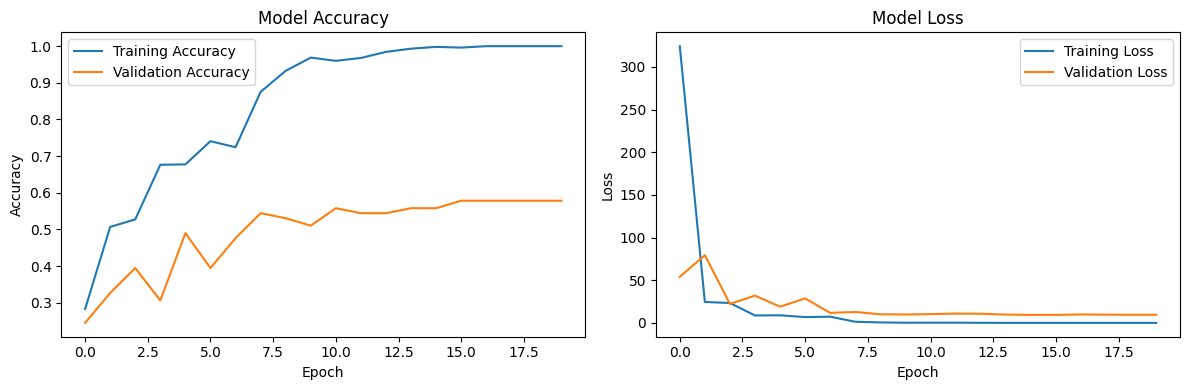

In [70]:
# 6. Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 7. Plot Training and Validation Metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Displaying confusion matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


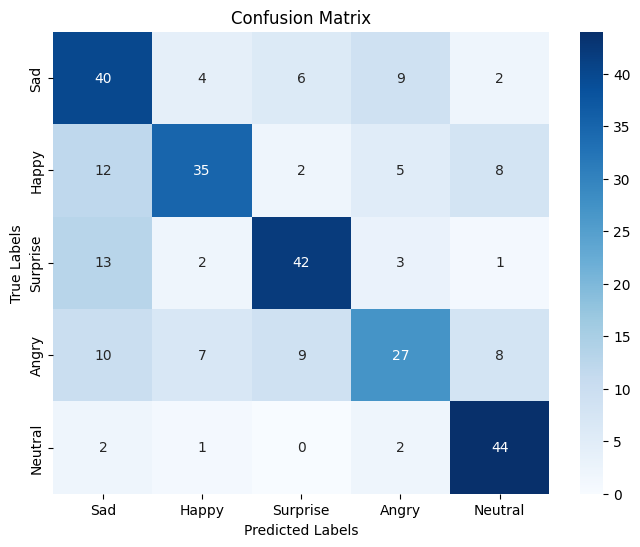

Classification Report:
              precision    recall  f1-score   support

         Sad       0.52      0.66      0.58        61
       Happy       0.71      0.56      0.63        62
    Surprise       0.71      0.69      0.70        61
       Angry       0.59      0.44      0.50        61
     Neutral       0.70      0.90      0.79        49

    accuracy                           0.64       294
   macro avg       0.65      0.65      0.64       294
weighted avg       0.64      0.64      0.63       294

Overall Accuracy: 0.6395


In [71]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_classes are defined
# Replace these with your actual test labels and predictions
y_pred_classes = np.argmax(model.predict(X_test), axis=1)  # Get predicted class indices

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class names
class_names = ['Sad', 'Happy', 'Surprise', 'Angry', 'Neutral'] #, 'Disgust

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1-score, and accuracy
report = classification_report(y_test, y_pred_classes, target_names=class_names)
accuracy = accuracy_score(y_test, y_pred_classes)

print("Classification Report:")
print(report)
print(f"Overall Accuracy: {accuracy:.4f}")


# Using proposed model -  CNN-Transformer Hybrid Approach

In [72]:
# Extract MFCC features
train_df['mfcc_features'] = train_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))
val_df['mfcc_features'] = val_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))
test_df['mfcc_features'] = test_df['standardized_audio'].apply(lambda x: pad_or_truncate(extract_mfcc(x)))

# Reshape MFCC features for train, validation, and test sets
X_train = np.stack(train_df['mfcc_features'].values).transpose(0, 2, 1) # Shape (batch_size, 300, 40)
X_val = np.stack(val_df['mfcc_features'].values).transpose(0, 2, 1)     # Shape (batch_size, 300, 40)
X_test = np.stack(test_df['mfcc_features'].values).transpose(0, 2, 1)   # Shape (batch_size, 300, 40)

# Prepare Labels
target_mapping = {'happy': 0, 'sad': 1, 'angry': 2, 'surprise': 3, 'neutral': 4, 'disgust': 5}
y_train = np.array([target_mapping[label] for label in train_df['labels']])
y_val = np.array([target_mapping[label] for label in val_df['labels']])
y_test = np.array([target_mapping[label] for label in test_df['labels']])

# Convert labels to categorical format
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=5)
y_val_cat = to_categorical(y_val, num_classes=5)
y_test_cat = to_categorical(y_test, num_classes=5)

# Verify shapes
print("X_train shape:", X_train.shape)       # Should be (num_samples_train, 300, 40)
print("X_val shape:", X_val.shape)           # Should be (num_samples_val, 300, 40)
print("X_test shape:", X_test.shape)         # Should be (num_samples_test, 300, 40)
print("y_train_cat shape:", y_train_cat.shape) # Should be (num_samples_train, num_classes=5)
print("y_val_cat shape:", y_val_cat.shape)     # Should be (num_samples_val, num_classes=5)
print("y_test_cat shape:", y_test_cat.shape)   # Should be (num_samples_test, num_classes=5)


X_train shape: (1026, 300, 40)
X_val shape: (147, 300, 40)
X_test shape: (294, 300, 40)
y_train_cat shape: (1026, 5)
y_val_cat shape: (147, 5)
y_test_cat shape: (294, 5)


# Code recieved from actual people

In [73]:
from tensorflow.keras import layers, models, regularizers

def build_cnn_backbone(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    # Modified to match PyTorch architecture
    x = layers.Conv1D(64, 3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv1D(64, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool1D(3)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv1D(128, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv1D(64, 3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool1D(3)(x)
    
    return models.Model(inputs, x, name="modified_cnn_backbone")

def transformer_block(x, num_heads, key_dim, mlp_dim, prefix):
    # Multi-head attention
    attn_output = layers.MultiHeadAttention(
        num_heads=num_heads, 
        key_dim=key_dim,
        name=f"{prefix}_attn"
    )(x, x)
    
    # First residual connection
    x = layers.Add(name=f"{prefix}_add1")([x, attn_output])
    x = layers.LayerNormalization(name=f"{prefix}_ln1")(x)
    
    # MLP
    mlp_output = layers.Dense(mlp_dim, activation='relu', name=f"{prefix}_mlp")(x)
    mlp_output = layers.Dense(key_dim, name=f"{prefix}_mlp_out")(mlp_output)
    
    # Second residual connection
    x = layers.Add(name=f"{prefix}_add2")([x, mlp_output])
    x = layers.LayerNormalization(name=f"{prefix}_ln2")(x)
    
    return x

def build_model(input_shape, num_classes):
    # Input
    inputs = layers.Input(shape=input_shape)
    
    # CNN Backbone
    cnn_backbone = build_cnn_backbone(input_shape)
    cnn_output = cnn_backbone(inputs)  # Shape: (None, 31, 64)
    
    # Attention blocks
    z = layers.Lambda(lambda x: x)(cnn_output)  # Save original features
    
    # First transformer block
    x = transformer_block(cnn_output, num_heads=4, key_dim=64, mlp_dim=64, prefix="block1")
    x = layers.ReLU()(x)
    
    # Second transformer block
    x = transformer_block(x, num_heads=4, key_dim=64, mlp_dim=64, prefix="block2")
    x = layers.ReLU()(x)
    
    # Concatenate CNN features with transformer output
    combined = layers.Concatenate(axis=-1)([z, x])  # Shape: (None, 31, 128)
    
    # Classifier head
    x = layers.Flatten()(combined)
    x = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    return models.Model(inputs, outputs)

# Model compilation
model = build_model((300, 40), 5)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 300, 40)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ modified_cnn_backbone         │ (None, 33, 64)            │          70,720 │ input_layer_4[0][0]        │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_attn                   │ (None, 33, 64)            │          66,368 │ modified_cnn_backbone[0][… │
│ (MultiHeadAttention)          │                           │                 │ modified_cnn_backbone[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_add1 (Add)             │ (None, 33, 64)            │               0 │ modified_cnn_backbone[0][… │
│                               │                           │                 │ block1_attn[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_ln1                    │ (None, 33, 64)            │             128 │ block1_add1[0][0]          │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_mlp (Dense)            │ (None, 33, 64)            │           4,160 │ block1_ln1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_mlp_out (Dense)        │ (None, 33, 64)            │           4,160 │ block1_mlp[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_add2 (Add)             │ (None, 33, 64)            │               0 │ block1_ln1[0][0],          │
│                               │                           │                 │ block1_mlp_out[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_ln2                    │ (None, 33, 64)            │             128 │ block1_add2[0][0]          │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_10 (ReLU)               │ (None, 33, 64)            │               0 │ block1_ln2[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_attn                   │ (None, 33, 64)            │          66,368 │ re_lu_10[0][0],            │
│ (MultiHeadAttention)          │                           │                 │ re_lu_10[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_add1 (Add)             │ (None, 33, 64)            │               0 │ re_lu_10[0][0],            │
│                               │                           │                 │ block2_attn[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_ln1                    │ (None, 33, 64)            │             128 │ block2_add1[0][0]          │
│ (LayerNormalization)          │                           │               

 Total params: 2,386,373 (9.10 MB)

 Trainable params: 2,385,733 (9.10 MB)

 Non-trainable params: 640 (2.50 KB)

## Defining the CNN-Transformer Hybrid Model

In [79]:
from tensorflow.keras.regularizers import l2
# CNN Backbone (Increased filters)
def build_cnn_backbone(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Conv1D Stack with More Filters
    x = layers.Conv1D(filters=512, kernel_size=5, strides=1, padding="same", activation="relu",
                      kernel_regularizer=l2(0.01))(inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu',
                      kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu',
                      kernel_regularizer=l2(0.01))(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(filters=128, kernel_size=10, strides=10, padding='valid', activation='relu',
                      kernel_regularizer=l2(0.01))(x)
    x = layers.Dropout(0.3)(x)

    return models.Model(inputs, x, name="cnn_backbone")

# Transformer Encoder (Increased complexity)
def build_transformer_encoder(input_shape, num_heads=6, ff_dim=512, num_layers=3):
    inputs = layers.Input(shape=input_shape)

    # Positional Encoding
    positions = tf.range(start=0, limit=input_shape[0], delta=1)
    positions = layers.Embedding(input_dim=input_shape[0], output_dim=128)(positions)  # Increased Embedding
    x = inputs + positions

    # Transformer Encoder Stack
    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=128)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        ffn_output = layers.Dense(ff_dim, activation='relu')(x)
        ffn_output = layers.Dense(128)(ffn_output)  # Match embedding size
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)

    return models.Model(inputs, x, name="transformer_encoder")

# Full Model
def build_model(input_shape, num_classes):
    # CNN Backbone
    cnn_backbone = build_cnn_backbone(input_shape)

    # Transformer Encoder
    transformer_input_shape = cnn_backbone.output_shape[1:]
    transformer_encoder = build_transformer_encoder(transformer_input_shape)

    # Combine CNN and Transformer
    cnn_output = cnn_backbone.output
    transformer_output = transformer_encoder(cnn_output)
    combined_output = layers.Concatenate(axis=-1)([cnn_output, transformer_output])

    # Global Average Pooling Instead of Flatten
    x = layers.GlobalAveragePooling1D()(combined_output)
    x = layers.Dense(256, activation="relu")(x)  # Increase Dense Layer Size
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(cnn_backbone.input, outputs, name="cnn_transformer_model")

# Reshape input data
X_train = X_train.reshape(-1, 300, 40)
X_val = X_val.reshape(-1, 300, 40)

# Build and Compile the Model
model = build_model((300, 40), num_classes=5)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "cnn_transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 300, 40)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_12 (Conv1D)            │ (None, 300, 512)          │         102,912 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_11        │ (None, 300, 512)          │           2,048 │ conv1d_12[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_13 (Conv1D)            │ (None, 300, 256)          │         393,472 │ batch_normalization_11[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_12        │ (None, 300, 256)          │           1,024 │ conv1d_13[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_14 (Conv1D)            │ (None, 300, 128)          │          98,432 │ batch_normalization_12[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 300, 128)          │             512 │ conv1d_14[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_15 (Conv1D)            │ (None, 30, 128)           │         163,968 │ batch_normalization_13[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_15 (Dropout)          │ (None, 30, 128)           │               0 │ conv1d_15[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ transformer_encoder           │ (None, 30, 128)           │       1,583,616 │ dropout_15[0][0]           │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 30, 256)           │               0 │ dropout_15[0][0],          │
│                               │                           │                 │ transformer_encoder[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ global_average_pooling1d_1    │ (None, 256)               │               0 │ concatenate_3[0][0]        │
│ (GlobalAveragePooling1D)      │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_26 (Dense)              │ (None, 256)               │          65,792 │ global_average_pooling1d_… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_19 (Dropout)          │ (None, 256)               │               0 │ dense_26[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 2,413,061 (9.21 MB)

 Trainable params: 2,411,269 (9.20 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [80]:
# Compute Class Weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Define Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('cnn-transformer.h5', monitor='val_loss', save_best_only=True)
]

# Train the Model
history = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat),
                    epochs=100, batch_size=32, class_weight=class_weights_dict,
                    callbacks=callbacks)

Epoch 1/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.3402 - loss: 8.5879

33/33 ━━━━━━━━━━━━━━━━━━━━ 15s 227ms/step - accuracy: 0.3423 - loss: 8.5787 - val_accuracy: 0.1905 - val_loss: 11.4409
Epoch 2/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.4728 - loss: 8.0624

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.4729 - loss: 8.0566 - val_accuracy: 0.1633 - val_loss: 10.3413
Epoch 3/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.4942 - loss: 7.6623

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 201ms/step - accuracy: 0.4954 - loss: 7.6567 - val_accuracy: 0.2653 - val_loss: 8.8767
Epoch 4/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5425 - loss: 7.2459

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.5436 - loss: 7.2401 - val_accuracy: 0.3265 - val_loss: 7.8540
Epoch 5/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.6237 - loss: 6.8737

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.6251 - loss: 6.8695 - val_accuracy: 0.4422 - val_loss: 7.3156
Epoch 6/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6732 - loss: 6.5689

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.6740 - loss: 6.5656 - val_accuracy: 0.4626 - val_loss: 6.9484
Epoch 7/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7806 - loss: 6.2197

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.7797 - loss: 6.2186 - val_accuracy: 0.5306 - val_loss: 6.6193
Epoch 8/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7721 - loss: 6.0588

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.7735 - loss: 6.0548 - val_accuracy: 0.5986 - val_loss: 6.3170
Epoch 9/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.7877 - loss: 5.8573

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.7879 - loss: 5.8567 - val_accuracy: 0.7279 - val_loss: 5.9298
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.8510 - loss: 5.6179 - val_accuracy: 0.7007 - val_loss: 5.9440
Epoch 11/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8245 - loss: 5.5267

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.8251 - loss: 5.5250 - val_accuracy: 0.7007 - val_loss: 5.8429
Epoch 12/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8840 - loss: 5.3196

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.8832 - loss: 5.3194 - val_accuracy: 0.7347 - val_loss: 5.6414
Epoch 13/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.8436 - loss: 5.3090 - val_accuracy: 0.5986 - val_loss: 5.9806
Epoch 14/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8116 - loss: 5.3049

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.8140 - loss: 5.2971 - val_accuracy: 0.6803 - val_loss: 5.6130
Epoch 15/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8996 - loss: 5.0380

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9003 - loss: 5.0343 - val_accuracy: 0.8367 - val_loss: 5.1817
Epoch 16/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9114 - loss: 4.8887 - val_accuracy: 0.6939 - val_loss: 5.4225
Epoch 17/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.9359 - loss: 4.7530 - val_accuracy: 0.7619 - val_loss: 5.2104
Epoch 18/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.9272 - loss: 4.6884 - val_accuracy: 0.6531 - val_loss: 5.4702
Epoch 19/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9443 - loss: 4.5956

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9444 - loss: 4.5940 - val_accuracy: 0.7279 - val_loss: 5.0842
Epoch 20/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.9722 - loss: 4.4548 - val_accuracy: 0.6871 - val_loss: 5.3192
Epoch 21/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.9281 - loss: 4.5344 - val_accuracy: 0.6531 - val_loss: 5.3656
Epoch 22/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 197ms/step - accuracy: 0.7654 - loss: 5.0398 - val_accuracy: 0.6190 - val_loss: 5.3117
Epoch 23/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.8844 - loss: 4.5158 - val_accuracy: 0.5782 - val_loss: 5.4995
Epoch 24/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.8177 - loss: 4.6443

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 204ms/step - accuracy: 0.8204 - loss: 4.6371 - val_accuracy: 0.7279 - val_loss: 5.0733
Epoch 25/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9243 - loss: 4.2956

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9251 - loss: 4.2935 - val_accuracy: 0.7483 - val_loss: 4.7663
Epoch 26/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9428 - loss: 4.2419

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 206ms/step - accuracy: 0.9427 - loss: 4.2415 - val_accuracy: 0.7823 - val_loss: 4.6944
Epoch 27/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 199ms/step - accuracy: 0.9858 - loss: 4.0863 - val_accuracy: 0.7483 - val_loss: 4.7222
Epoch 28/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9433 - loss: 4.1533

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9437 - loss: 4.1521 - val_accuracy: 0.8027 - val_loss: 4.6224
Epoch 29/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.9802 - loss: 4.0148

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9804 - loss: 4.0132 - val_accuracy: 0.7959 - val_loss: 4.4711
Epoch 30/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9861 - loss: 3.9180

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9862 - loss: 3.9176 - val_accuracy: 0.8367 - val_loss: 4.4689
Epoch 31/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 200ms/step - accuracy: 0.9009 - loss: 4.1600 - val_accuracy: 0.6531 - val_loss: 4.9354
Epoch 32/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 198ms/step - accuracy: 0.9485 - loss: 3.9675 - val_accuracy: 0.7687 - val_loss: 4.5709
Epoch 33/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.9741 - loss: 3.8349

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 203ms/step - accuracy: 0.9742 - loss: 3.8346 - val_accuracy: 0.8231 - val_loss: 4.3630
Epoch 34/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step - accuracy: 0.9345 - loss: 3.9238 - val_accuracy: 0.7279 - val_loss: 4.6073
Epoch 35/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 253ms/step - accuracy: 0.8917 - loss: 3.9867 - val_accuracy: 0.6667 - val_loss: 4.7127
Epoch 36/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.9565 - loss: 3.7707 - val_accuracy: 0.7279 - val_loss: 4.4899
Epoch 37/100
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.9827 - loss: 3.6872

33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 207ms/step - accuracy: 0.9827 - loss: 3.6865 - val_accuracy: 0.8299 - val_loss: 4.1676
Epoch 38/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 211ms/step - accuracy: 0.9882 - loss: 3.6242 - val_accuracy: 0.8231 - val_loss: 4.2012
Epoch 39/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.9866 - loss: 3.5954 - val_accuracy: 0.7959 - val_loss: 4.2445
Epoch 40/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9267 - loss: 3.7054 - val_accuracy: 0.7415 - val_loss: 4.4939
Epoch 41/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - accuracy: 0.9483 - loss: 3.6125 - val_accuracy: 0.7891 - val_loss: 4.2432
Epoch 42/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 7s 223ms/step - accuracy: 0.9695 - loss: 3.5216 - val_accuracy: 0.7959 - val_loss: 4.3328


In [81]:
X_test = X_test.reshape(-1, 300, 40)  # Reshape to (294, 300, 40)

print("X_test shape:", X_test.shape)
print("y_test_cat shape:", y_test_cat.shape)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

X_test shape: (294, 300, 40)
y_test_cat shape: (294, 5)
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.8461 - loss: 4.1447
Test Loss: 4.2170
Test Accuracy: 0.8197


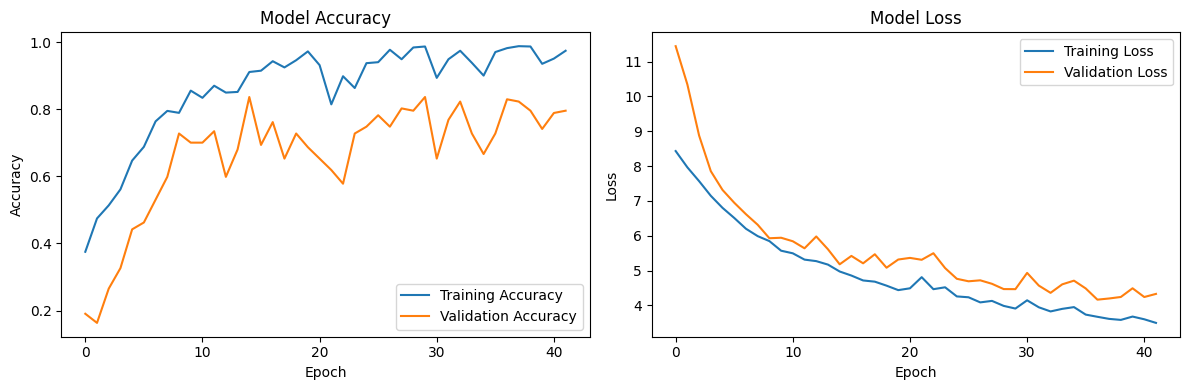

In [82]:
# Plot training and validation metrics
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step 


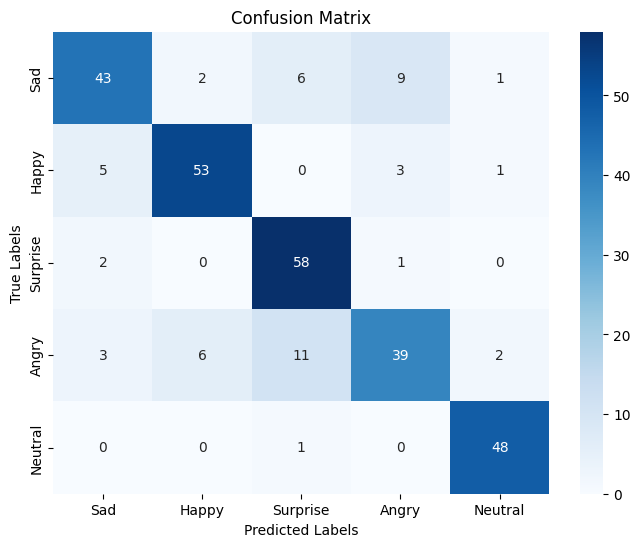

Classification Report:
              precision    recall  f1-score   support

         Sad       0.81      0.70      0.75        61
       Happy       0.87      0.85      0.86        62
    Surprise       0.76      0.95      0.85        61
       Angry       0.75      0.64      0.69        61
     Neutral       0.92      0.98      0.95        49

    accuracy                           0.82       294
   macro avg       0.82      0.83      0.82       294
weighted avg       0.82      0.82      0.82       294

Overall Accuracy: 0.8197


In [83]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix


# Assuming model, X_test, and y_test are defined
# Convert predictions to class indices
X_test = X_test.reshape(-1, 300, 40)  # Reshape to (294, 300, 40)

y_pred_classes = np.argmax(model.predict(X_test), axis=1)  # Get predicted labels

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Define class names (Modify this according to your dataset)
class_names = ['Sad', 'Happy', 'Surprise', 'Angry', 'Neutral'] #, 'Disgust'

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision, recall, F1-score, and accuracy
report = classification_report(y_test, y_pred_classes, target_names=class_names)
accuracy = accuracy_score(y_test, y_pred_classes)

# Print the results
print("Classification Report:")
print(report)
print(f"Overall Accuracy: {accuracy:.4f}")